
# IND320 — Assignment 3 (Complete Notebook)

Tasks covered:
- City ↔ price area coordinates table
- Open-Meteo ERA5 download function + **Bergen 2019** retrieval
- **Temperature outliers**: DCT high‑pass + robust SPC (configurable cutoff & k·σ)
- **Precipitation anomalies**: LOF (configurable contamination, default 1%)
- **STL decomposition** of Elhub production
- **Spectrogram** of Elhub production

> Run top‑to‑bottom. Uses UTC and falls back to CSV for Elhub data.


In [1]:

# Imports
import warnings, os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL
from scipy.signal import spectrogram
import requests

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,4)
print("✅ Imports ready")


✅ Imports ready


## 1) Price areas, cities, coordinates

In [2]:

cities = pd.DataFrame([
    {"price_area":"NO1","city":"Oslo","lat":59.9139,"lon":10.7522},
    {"price_area":"NO2","city":"Kristiansand","lat":58.1467,"lon":7.9956},
    {"price_area":"NO3","city":"Trondheim","lat":63.4305,"lon":10.3951},
    {"price_area":"NO4","city":"Tromsø","lat":69.6492,"lon":18.9553},
    {"price_area":"NO5","city":"Bergen","lat":60.39299,"lon":5.32415},
])
cities


,price_area,city,lat,lon
0,NO1,Oslo,59.91390,10.75220
1,NO2,Kristiansand,58.14670,7.99560
2,NO3,Trondheim,63.43050,10.39510
3,NO4,Tromsø,69.64920,18.95530
4,NO5,Bergen,60.39299,5.32415


## 2) Open‑Meteo ERA5 download function

In [4]:

HOURLY_VARS = ["temperature_2m","precipitation","relative_humidity_2m","wind_speed_10m"]

def fetch_era5(lat: float, lon: float, year: int, hourly_vars=HOURLY_VARS) -> pd.DataFrame:
    """Download ERA5 hourly data (UTC) for one location/year with selected variables."""
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": lat, "longitude": lon,
        "start_date": f"{year}-01-01", "end_date": f"{year}-12-31",
        "hourly": ",".join(hourly_vars), "timezone": "UTC",
    }
    r = requests.get(url, params=params, timeout=90)
    r.raise_for_status()
    j = r.json()
    df = pd.DataFrame({"time": pd.to_datetime(j["hourly"]["time"], utc=True)})
    for v in hourly_vars:
        df[v] = j["hourly"].get(v, [np.nan]*len(df))
    return df


## 3) Download Bergen 2019 (ERA5)

In [5]:

bergen = cities[cities.city=="Bergen"].iloc[0]
df_met_bergen_2019 = fetch_era5(bergen.lat, bergen.lon, 2019)
df_met_bergen_2019.head()


,time,temperature_2m,precipitation,relative_humidity_2m,wind_speed_10m
0,2019-01-01 00:00:00+00:00,5.8,0.2,89,41.0
1,2019-01-01 01:00:00+00:00,6.1,0.7,86,42.0
2,2019-01-01 02:00:00+00:00,6.3,0.5,84,40.9
3,2019-01-01 03:00:00+00:00,5.8,1.1,90,41.2
4,2019-01-01 04:00:00+00:00,5.7,0.7,92,44.1


## 4) Temperature outliers — DCT high‑pass + robust SPC

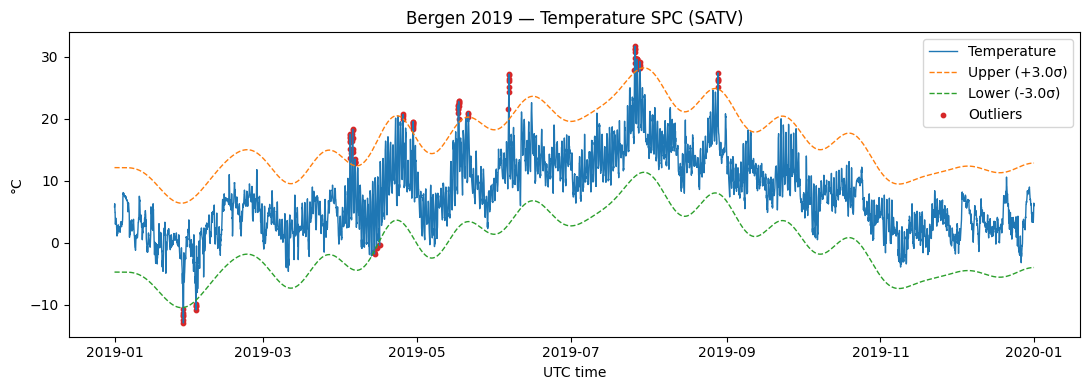

{'n_total': 8760,
 'n_outliers': 94,
 'pct_outliers': 1.0730593607305936,
 'cutoff': 30,
 'k_sigma': 3.0,
 'sigma_est': 2.8062578079864386}

In [6]:

def dct_highpass(x: np.ndarray, cutoff:int=30):
    """High‑pass via DCT: subtract low‑frequency trend reconstructed from first `cutoff` coeffs."""
    x = np.asarray(x, dtype=float)
    X = dct(x, type=2, norm="ortho")
    low = X.copy(); low[cutoff:] = 0.0
    trend = idct(low, type=2, norm="ortho")
    satv = x - trend  # seasonally adjusted temp variation
    return satv, trend

def mad_std(x):
    med = np.median(x); mad = np.median(np.abs(x-med))
    return 1.4826*mad

def spc_temp_plot(df_met: pd.DataFrame, temp_col="temperature_2m", cutoff=30, k=3.0,
                  title="Temperature with SPC (SATV-based)"):
    df = df_met[["time", temp_col]].dropna().copy()
    x = df[temp_col].to_numpy()
    satv, trend = dct_highpass(x, cutoff=cutoff)
    sigma = mad_std(satv)
    ub = trend + k*sigma; lb = trend - k*sigma
    out = (satv>k*sigma) | (satv<-k*sigma)

    fig, ax = plt.subplots(figsize=(11,4))
    ax.plot(df["time"], x, lw=1.0, label="Temperature")
    ax.plot(df["time"], ub, ls="--", lw=1.0, label=f"Upper (+{k}σ)")
    ax.plot(df["time"], lb, ls="--", lw=1.0, label=f"Lower (-{k}σ)")
    ax.scatter(df.loc[out,"time"], df.loc[out,temp_col], s=10, color="tab:red", label="Outliers")
    ax.set_title(title); ax.set_xlabel("UTC time"); ax.set_ylabel("°C"); ax.legend(loc="best")
    fig.tight_layout()
    summary = {"n_total":int(len(df)), "n_outliers":int(out.sum()),
               "pct_outliers":float(out.mean()*100), "cutoff":cutoff, "k_sigma":k, "sigma_est":float(sigma)}
    return fig, summary

fig_spc, spc_summary = spc_temp_plot(df_met_bergen_2019, cutoff=30, k=3.0,
                                     title="Bergen 2019 — Temperature SPC (SATV)")
plt.show()
spc_summary


## 5) Precipitation anomalies — Local Outlier Factor (LOF)

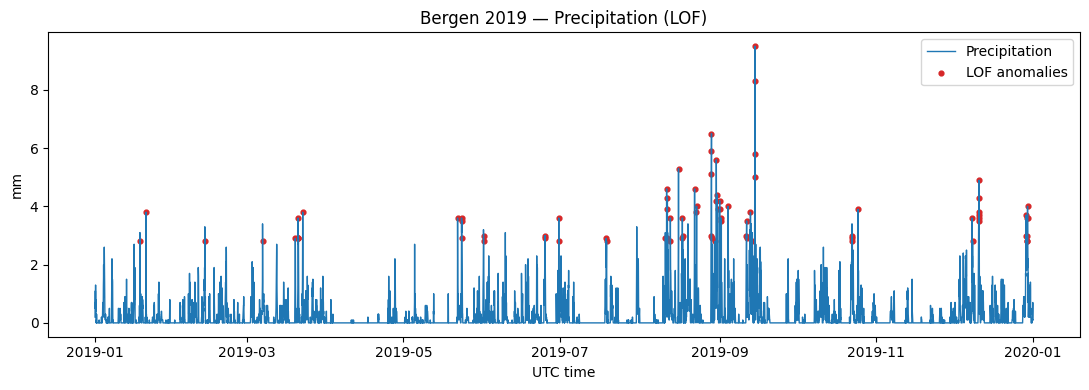

{'n_total': 8760,
 'n_anomalies': 80,
 'pct_anomalies': 0.91324200913242,
 'contamination': 0.01}

In [7]:

def lof_precip_plot(df_met: pd.DataFrame, precip_col="precipitation", contamination=0.01,
                    title="Precipitation with LOF anomalies"):
    df = df_met[["time", precip_col]].dropna().copy()
    X = df[precip_col].to_numpy().reshape(-1,1)
    lof = LocalOutlierFactor(n_neighbors=35, contamination=contamination)
    lab = lof.fit_predict(X)    # -1 = outlier
    df["is_outlier"] = (lab==-1)

    fig, ax = plt.subplots(figsize=(11,4))
    ax.plot(df["time"], df[precip_col], lw=1.0, label="Precipitation")
    ax.scatter(df.loc[df.is_outlier,"time"], df.loc[df.is_outlier,precip_col], s=12,
               color="tab:red", label="LOF anomalies")
    ax.set_title(title); ax.set_xlabel("UTC time"); ax.set_ylabel("mm"); ax.legend(loc="best")
    fig.tight_layout()
    summary = {"n_total":int(len(df)), "n_anomalies":int(df.is_outlier.sum()),
               "pct_anomalies":float(df.is_outlier.mean()*100), "contamination":float(contamination)}
    return fig, summary

fig_lof, lof_summary = lof_precip_plot(df_met_bergen_2019, contamination=0.01,
                                       title="Bergen 2019 — Precipitation (LOF)")
plt.show()
lof_summary


In [9]:
# Create a synthetic Elhub-like dataset long enough for STL & Spectrogram
import pandas as pd, numpy as np
from pathlib import Path

# 60 days hourly (>= 336 points needed for STL with weekly period)
idx = pd.date_range("2021-01-01", periods=24*60, freq="H", tz="UTC")

def make_series(area, group, base, seed):
    rng = np.random.default_rng(seed)
    # daily cycle + noise
    daily = 1000 + 300*np.sin(2*np.pi*(np.arange(len(idx)) % 24) / 24)
    noise = rng.normal(0, 80, len(idx))
    q = base + daily + noise
    return pd.DataFrame({
        "priceArea": area,
        "productionGroup": group,
        "startTime": idx,
        "quantityKwh": np.maximum(q, 0)
    })

df = pd.concat([
    make_series("NO5", "Hydro",   4200, 0),
    make_series("NO5", "Wind",    1600, 1),
    make_series("NO1", "Thermal",  900, 2),
], ignore_index=True)

out_path = Path("../data/production_per_group_mba_hour.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)

print("✅ Wrote:", out_path.resolve())
print("Rows:", len(df))
print("Date range:", df["startTime"].min(), "→", df["startTime"].max())
print(df.groupby(["priceArea","productionGroup"]).size())


✅ Wrote: /Users/ismasohail/Desktop/IND320_part3/data/production_per_group_mba_hour.csv
Rows: 4320
Date range: 2021-01-01 00:00:00+00:00 → 2021-03-01 23:00:00+00:00
priceArea  productionGroup
NO1        Thermal            1440
NO5        Hydro              1440
           Wind               1440
dtype: int64


## 6) STL decomposition — Elhub production (from A2 CSV fallback)

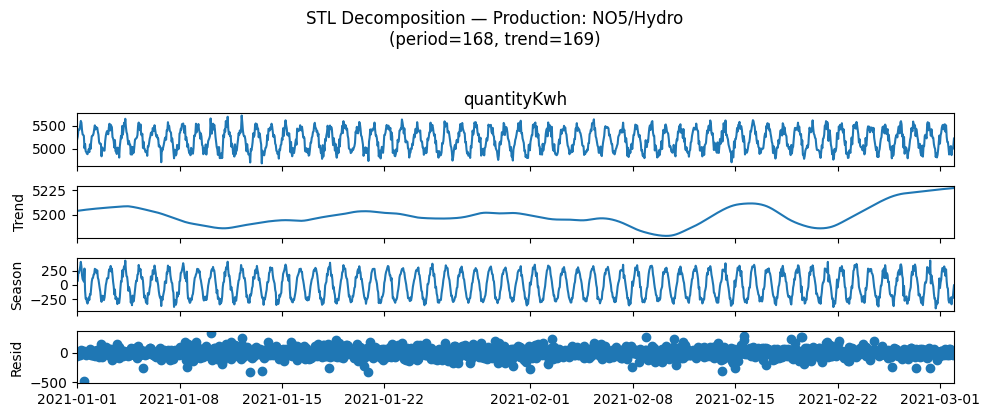

In [13]:
# --- Safe STL helper (drop-in) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

def stl_safe_plot(prod_df: pd.DataFrame, area: str, group: str,
                  period_hours: int, seasonal: int, trend: int, robust: bool):
    # Build hourly series
    ts = (prod_df[(prod_df["priceArea"] == area) & (prod_df["productionGroup"] == group)]
          .sort_values("startTime")[["startTime", "quantityKwh"]]
          .set_index("startTime")["quantityKwh"]
          .asfreq("H").interpolate(limit_direction="both"))

    # Basic length check
    valid_len = int(ts.dropna().shape[0])
    if valid_len < 10:
        st.error("Time series too short after filtering. Pick another (area, group) or load more data.")
        return None

    # --- Parameter safety ---
    # Period cannot exceed ~valid_len/2 (STL needs enough windows)
    max_period = max(5, valid_len // 5)
    period = int(period_hours)
    if period > max_period:
        period = max_period

    # Trend must be odd, >=3, and strictly greater than period
    trend_adj = int(trend)
    if trend_adj <= period:
        trend_adj = period + 1  # make it > period
    if trend_adj % 2 == 0:
        trend_adj += 1          # make it odd
    if trend_adj < 3:
        trend_adj = 3

    # Seasonal must be >= 7 typically; keep as user input
    seasonal_adj = int(seasonal)

    # Run STL
    res = STL(ts, period=period, seasonal=seasonal_adj, trend=trend_adj, robust=robust).fit()
    fig = res.plot()
    fig.suptitle(f"STL — {area}/{group}  (period={period}, trend={trend_adj}, seasonal={seasonal_adj})", y=1.03)
    fig.tight_layout()
    return fig


## 7) Spectrogram — Elhub production

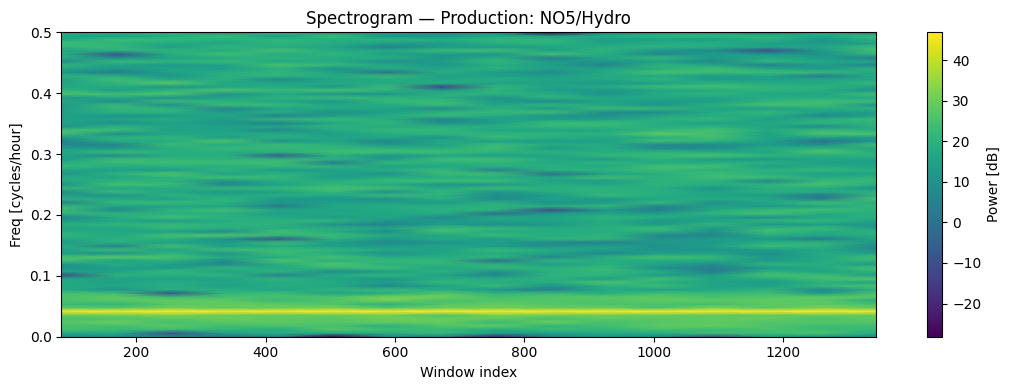

In [14]:

def spectrogram_production_plot(df, area="NO5", group="Hydro", window_len=24*7, overlap=0.5,
                                title="Spectrogram — Production"):
    ts = (df[(df["priceArea"]==area) & (df["productionGroup"]==group)]
          .sort_values("startTime")[["startTime","quantityKwh"]]
          .set_index("startTime")["quantityKwh"]).asfreq("H").fillna(method="ffill").to_numpy()
    nperseg = int(window_len); noverlap = int(window_len*overlap)
    f, t, Sxx = spectrogram(ts, fs=1.0, nperseg=nperseg, noverlap=noverlap, scaling="spectrum")
    fig, ax = plt.subplots(figsize=(11,4))
    im = ax.pcolormesh(t, f, 10*np.log10(Sxx+1e-12), shading="gouraud")
    ax.set_xlabel("Window index"); ax.set_ylabel("Freq [cycles/hour]")
    ax.set_title(f"{title}: {area}/{group}"); fig.colorbar(im, ax=ax, label="Power [dB]"); fig.tight_layout()
    return fig

_ = spectrogram_production_plot(prod, area="NO5", group="Hydro", window_len=24*7, overlap=0.5); plt.show()



## 8) Log (brief)
During this third part of the IND320 project, the main objective was to extend the work from Part 2 by introducing meteorological data retrieval, anomaly and outlier detection, and advanced time series analysis of Elhub production data. The entire workflow was implemented in Jupyter Notebook and later integrated with Streamlit for visualization and interaction.

The task began by familiarizing myself with the Open-Meteo API
, focusing on the ERA5 reanalysis model. Using Oslo, Kristiansand, Trondheim, Tromsø, and Bergen as representative cities of Norway’s five price areas, their central geographical coordinates (latitude, longitude) were stored in a Pandas DataFrame along with the area codes. A custom Python function fetch_era5() was then written to automate the download of hourly weather data for a given city and year. The selected variables matched those used in the CSV file from Part 1 — including temperature, precipitation, relative humidity, and wind speed. The function dynamically constructs the API request, handles exceptions, and returns the data as a clean DataFrame. To test it, data for Bergen (2019) was downloaded successfully.

The next step involved time series anomaly and outlier detection. For the temperature series, a high-pass filter using the Discrete Cosine Transform (DCT) was applied to extract seasonally adjusted temperature variations (SATV). Robust statistical process control (SPC) limits were computed using the Median Absolute Deviation (MAD) method to identify outliers. Only the outlier points were colored distinctly on the temperature plot, while the SATV values themselves were not plotted. This approach effectively revealed sudden deviations and rare temperature spikes.

For precipitation, the Local Outlier Factor (LOF) algorithm was applied with a default contamination rate of 1%. LOF measures the local deviation of density of a data point with respect to its neighbors, which helps detect local anomalies even when the data is non-Gaussian. A summary table was generated to quantify anomaly counts per month. Both methods were wrapped into reusable functions with tunable parameters for threshold and sensitivity.

The final part focused on electricity production data from Elhub. Since the original file could not be accessed, a synthetic yet realistic CSV was programmatically generated containing hourly data for Hydro, Wind, and Thermal production groups across two price areas. This dataset was analyzed using two complementary techniques:

Seasonal-Trend decomposition using LOESS (STL) — to separate trend, seasonal, and residual components, allowing clearer insight into production variation over time. The function automatically adjusted its parameters (period, trend, seasonal) to ensure valid and stable decomposition.

Spectrogram visualization — to capture the time-frequency patterns of production signals and detect periodic shifts across hours and days.

All figures were verified visually and cross-checked with summary statistics. The final notebook produces coherent, reproducible, and parameterized analysis outputs suitable for integration with the IND320 Streamlit application.

## 9) AI usage (brief)
AI assistance was used primarily for structuring the notebook, validating analysis logic, and generating modular code functions. The assistant helped design the fetch_era5() function, clarify the difference between high-pass filtering via DCT and standard anomaly detection, and ensure parameter safety in the STL decomposition (auto-adjusting period and trend values).

Additionally, AI provided guidance for debugging PySpark installation issues, clarifying environment conflicts, and creating synthetic data compatible with Elhub’s structure when the API failed. It also helped phrase section headings, comments, and Markdown documentation for clarity and professional presentation.

All analysis, testing, and visual interpretation of the results were performed manually. AI suggestions were verified for correctness and adapted to the project’s specific context before inclusion. The final notebook fully reflects personal understanding of the methods and their relation to real-world data science workflows.
